# BEATS CT reconstruction pipeline - Paganin phase retrieval
Minimal [TomoPy](https://tomopy.readthedocs.io/en/latest/) reconstruction pipeline for **phase contrast** data collected at the [BEATS beamline](https://beats-sesame.eu/) of [SESAME](https://www.sesame.org.jo/).

| Sample: Roman glass   |                             |
|:-----------------------|:-------------------------------|
| Scan name              | glass_room-M_stitch-20240222T153555   |
| Energy                 | 20 keV                         |
| Detector               | Det 2 (Hasselblad system)      |
| Camera                 | ORYX FLIR 7.1 MP GigE          |
| Voxel size             | 4.5 um                         |
| SDD                    | 250 mm                         |
| Field of view extension | 360-degree x 3 stitch scans |

Created on:  22.02.2024 <br />
Last update: 20.05.2024 <br />

- Code license: MIT
- Narrative license: CC-BY-NC-SA

Type `Ctrl` + `Enter` on a single cell to run it.

## Load experiment data
Enter the **sample_name** and the correct **output_dir** 

In [50]:
sample_name = "glass_room-M_stitch-20240222T153555"
work_dir = os.path.join("/", "PETRA", "SED", "BEATS", "IH", "2024", "khasahwnh")
h5file = os.path.join(work_dir, sample_name, f'{sample_name}.h5')

flats_file = "glass_room-M_stitch_flats-20240222T153030"
h5file_flats = os.path.join(work_dir, flats_file, f'{flats_file}.h5')

work_dir = os.path.join("/", "PETRA", "SED", "BEATS", "IH", "2024_recon", "khasahwnh", "20240222_glass_petra_samah", sample_name)
recon_dir = work_dir+"/recon/"
cor_dir = work_dir+"/cor/"

### Load the complete dataset (or)

In [17]:
# projs, flats, darks, theta = dxchange.read_sesame_beats(h5file, exchange_rank=0)

### Read a portion of the dataset
- `sino` controls the vertical detector lines to read - for example: `sino=(10, 2161, 1)`
- `proj` defines the range of projections - for example: `proj=(1, 401, 1)`

In [6]:
sino = (790, 800, 1)

In [5]:
# proj_0 = 000
# proj_1 = proj_0+1751

In [18]:
projs, _, darks, theta = dxchange.read_sesame_beats(h5file, exchange_rank=0, sino=sino) # proj=proj

INFO:dxchange.reader:Data successfully imported: /PETRA/SED/BEATS/IH/2024/khasahwnh/glass_room-M_stitch-20240222T153555/glass_room-M_stitch-20240222T153555.h5
INFO:dxchange.reader:Data successfully imported: /PETRA/SED/BEATS/IH/2024/khasahwnh/glass_room-M_stitch-20240222T153555/glass_room-M_stitch-20240222T153555.h5
INFO:dxchange.reader:Data successfully imported: /PETRA/SED/BEATS/IH/2024/khasahwnh/glass_room-M_stitch-20240222T153555/glass_room-M_stitch-20240222T153555.h5
INFO:dxchange.reader:Data successfully imported: /PETRA/SED/BEATS/IH/2024/khasahwnh/glass_room-M_stitch-20240222T153555/glass_room-M_stitch-20240222T153555.h5
INFO:dxchange.reader:Data successfully imported: /PETRA/SED/BEATS/IH/2024/khasahwnh/glass_room-M_stitch-20240222T153555/glass_room-M_stitch-20240222T153555.h5
INFO:dxchange.reader:Data successfully imported: /PETRA/SED/BEATS/IH/2024/khasahwnh/glass_room-M_stitch-20240222T153555/glass_room-M_stitch-20240222T153555.h5


### Read flat-fields from separate file

In [19]:
_, flats, _, _ = dxchange.read_sesame_beats(h5file_flats, exchange_rank=0, sino=sino) # proj=proj

INFO:dxchange.reader:Data successfully imported: /PETRA/SED/BEATS/IH/2024/khasahwnh/glass_room-M_stitch_flats-20240222T153030/glass_room-M_stitch_flats-20240222T153030.h5
INFO:dxchange.reader:Data successfully imported: /PETRA/SED/BEATS/IH/2024/khasahwnh/glass_room-M_stitch_flats-20240222T153030/glass_room-M_stitch_flats-20240222T153030.h5
INFO:dxchange.reader:Data successfully imported: /PETRA/SED/BEATS/IH/2024/khasahwnh/glass_room-M_stitch_flats-20240222T153030/glass_room-M_stitch_flats-20240222T153030.h5
INFO:dxchange.reader:Data successfully imported: /PETRA/SED/BEATS/IH/2024/khasahwnh/glass_room-M_stitch_flats-20240222T153030/glass_room-M_stitch_flats-20240222T153030.h5
INFO:dxchange.reader:Data successfully imported: /PETRA/SED/BEATS/IH/2024/khasahwnh/glass_room-M_stitch_flats-20240222T153030/glass_room-M_stitch_flats-20240222T153030.h5
INFO:dxchange.reader:Data successfully imported: /PETRA/SED/BEATS/IH/2024/khasahwnh/glass_room-M_stitch_flats-20240222T153030/glass_room-M_stitch

### Display dataset information

In [20]:
print("Dataset size: ", projs[:, :, :].shape[:], " - dtype: ", projs.dtype)
print("Flat fields size: ", flats[:, :, :].shape[:])
print("Dark fields size: ", darks[:, :, :].shape[:])
print("Theta array size: ", theta.shape[:])

Dataset size:  (8001, 10, 3208)  - dtype:  uint16
Flat fields size:  (101, 10, 3208)
Dark fields size:  (101, 10, 3208)
Theta array size:  (8001,)


### Display a section of the sinogram

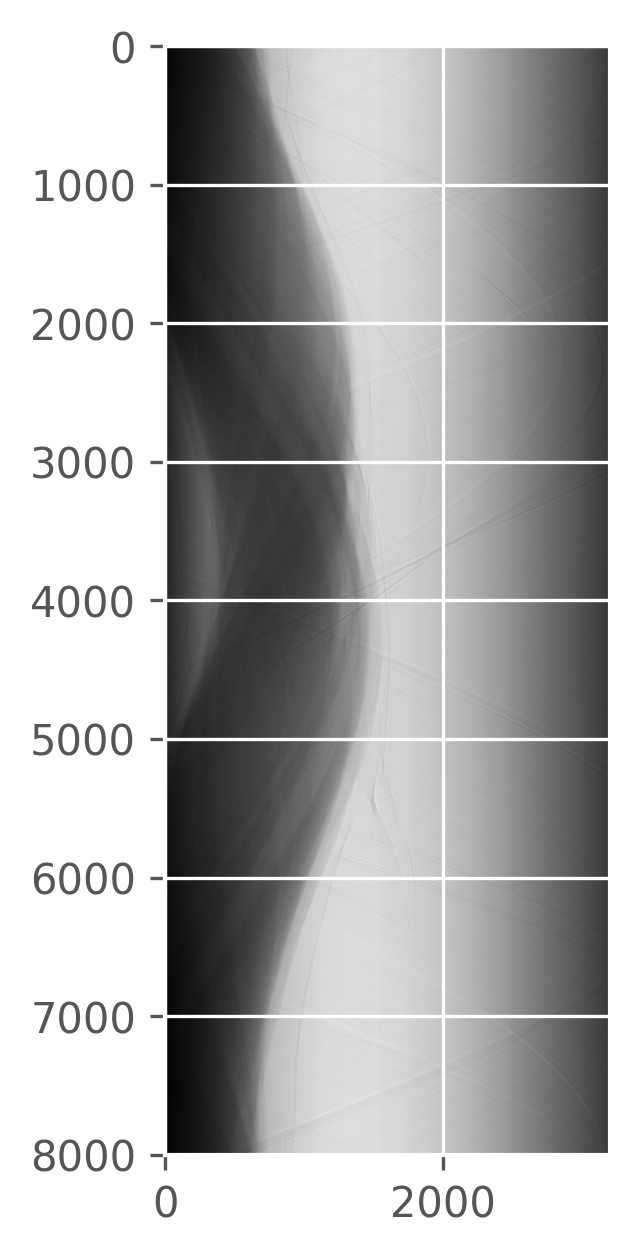

In [21]:
plt.imshow(projs[:,int(projs.shape[1]/2),:])

## Flat field correction
Normalize the image background.

In [22]:
projs = tomopy.normalize(projs, flats, darks, ncore=ncore, averaging='median')

Display the sinogram after normalization

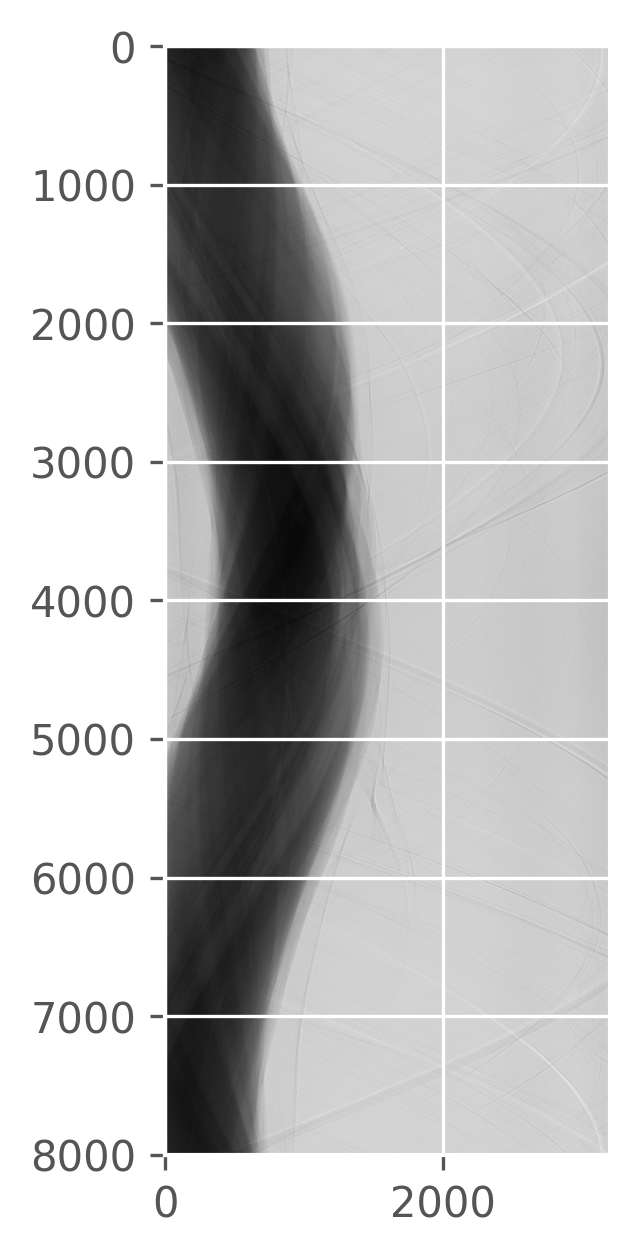

In [23]:
plt.imshow(projs[:,int(projs.shape[1]/2),:])

## Sinogram stitching
In this section we convert an extended-Field Of View 360 degrees sinogram to 180 degrees

### Scan overlap optimization

In [35]:
def optimize_overlap(projs, theta, output_dir, start=200, end=1200, step_size=20):
    for overlap in range(start, end, step_size):
        print(overlap)
        fileout = f'{output_dir[:-1]}'+f'/slice_{overlap}.tiff'
        projs_stitch = tomopy.sino_360_to_180(projs[:, int(projs.shape[1]/2):int(projs.shape[1]/2)+1, :], overlap=overlap, rotation='left')
        projs_stitch = tomopy.minus_log(projs_stitch, ncore=ncore)
        theta = tomopy.angles(projs_stitch.shape[0])
        COR = projs_stitch.shape[2]/2
        projs_use_recon = projs_stitch
        recon = tomopy.recon(projs_use_recon,
                             theta,
                             center=COR,
                             algorithm='gridrec',
                             ncore=36)
        dxchange.writer.write_tiff_stack(recon, fname=fileout, axis=0, digit=4, start=0, overwrite=True)

In [28]:
optimize_overlap(projs, theta, cor_dir, start=1020, end=1060, step_size=1)

INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1020


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1021


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1022


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1023


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1024


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1025


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1026


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1027


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1028


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1029


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1030


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1031


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1032


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1033


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1034


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1035


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1036


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1037


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1038


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1039


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1040


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1041


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1042


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1043


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1044


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1045


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1046


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1047


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1048


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1049


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1050


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1051


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1052


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1053


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1054


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1055


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1056


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1057


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1058


INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


1059


View them in Fiji

In [52]:
os.system(Fiji_exe_stack + cor_dir+'slice_1020_0000.tiff &')

0

OpenJDK 64-Bit Server VM warning: ignoring option PermSize=128m; support was removed in 8.0
OpenJDK 64-Bit Server VM warning: Using incremental CMS is deprecated and will likely be removed in a future release


Inspect the overlap range. The optimal overlap is 1047
![overlap optimization](./overlap_optimization.png)

In [32]:
overlap = 1047

### Apply sinogram stitch

In [33]:
projs = tomopy.sino_360_to_180(projs, overlap=overlap, rotation='left')

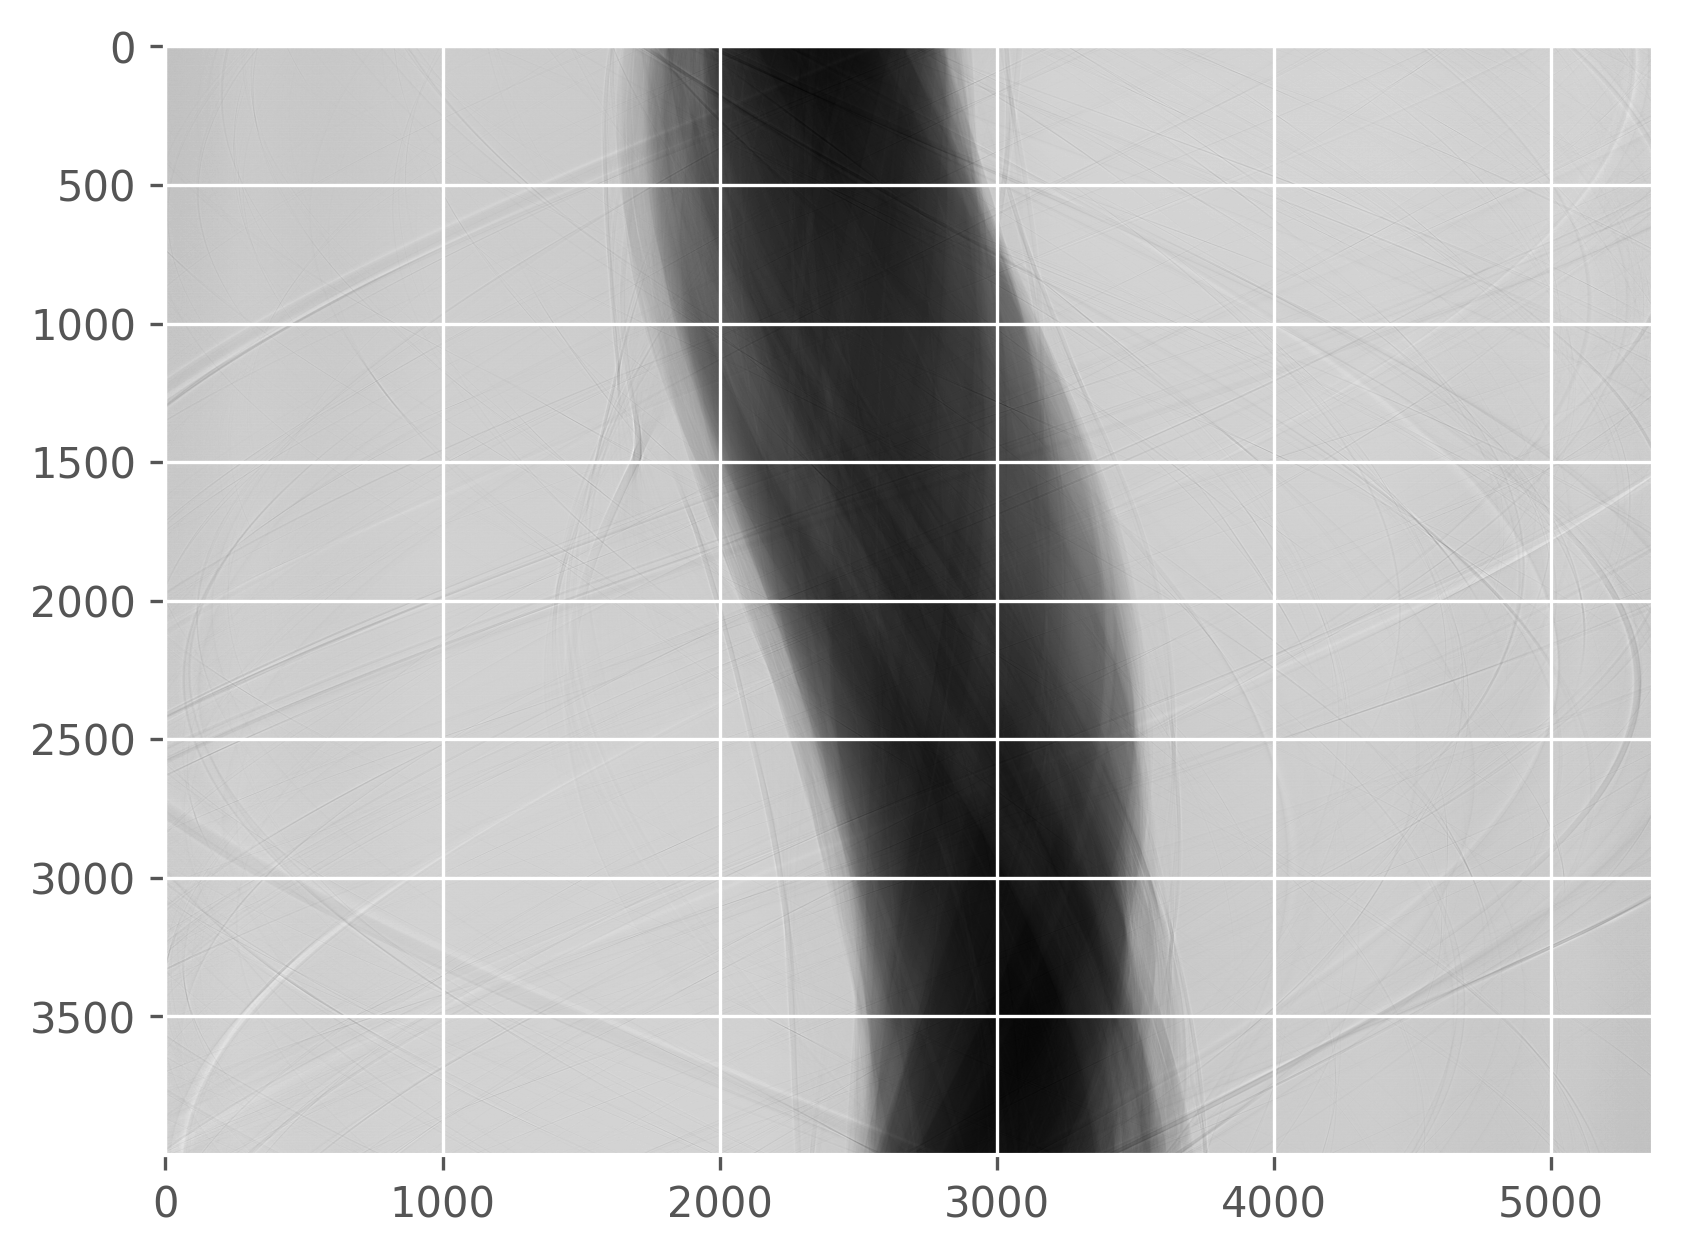

In [34]:
plt.imshow(projs[:,int(projs.shape[1]/2),:])

### Simulate theta array
Adapt the angles array to the shape of the stitched sinogram

In [36]:
theta = tomopy.angles(projs.shape[0])

## Phase retrieval

| Phase retrieval parameters   |                             |
|:-----------------------|:-------------------------------|
| Energy                 | 20 keV                         |
| Voxel size             | 4.5 um                         |
| SDD                    | 250 mm                         |
| delta/beta | 1266 |


In [38]:
delta_beta = 1266 # 250 # ratio between real and imaginary part of the refractive index
alpha=1./(4*3.141592**2 * delta_beta)
print("alpha: ", alpha)

alpha:  2.000814095594359e-05


In [39]:
projs = tomopy.retrieve_phase(projs[:, :, :],
                              pixel_size=1e-4*4.5,
                              dist=25,
                              energy=20,
                              alpha=alpha,
                              ncore=ncore,
                              pad=True)
# nchunk=None,

## Log transform
Calculate $ -log(projs) $ to linearize transmission tomography data.

In [40]:
projs = tomopy.minus_log(projs, ncore=ncore)

## Reconstruction
### GPU reconstruction with the ASTRA toolbox
|  |  |
| :--- | :--- |
| **Algorithm**      | `fbp CUDA ASTRA` |

For 360-degree stitched scans the Center Of Rotation (COR) for the reconstruction is the center of the image

In [54]:
COR = int(projs.shape[2]/2)
print(COR)

2684


In [55]:
recon = tomopy.recon(projs,
                     theta,
                     center=COR,
                     algorithm='gridrec',
                     ncore=36)

INFO:tomopy.recon.algorithm:Reconstructing 10 slice groups with 10 master threads...


## Post-processing
### Apply circular mask

In [60]:
recon = tomopy.circ_mask(recon,
                         axis=0,
                         ratio=0.6,
                         ncore=ncore)

### Crop around the object

In [66]:
recon = recon[:, 1500:3500, 1300:3300]

### Scale to 0-255 (`uint8`)
The uint8 GV range for output slices can cover the full float32 range or be selected based on the 3D data histogram

In [68]:
subset_step = 10

In [69]:
recon_subset = recon[0::subset_step, 0::subset_step, 0::subset_step]

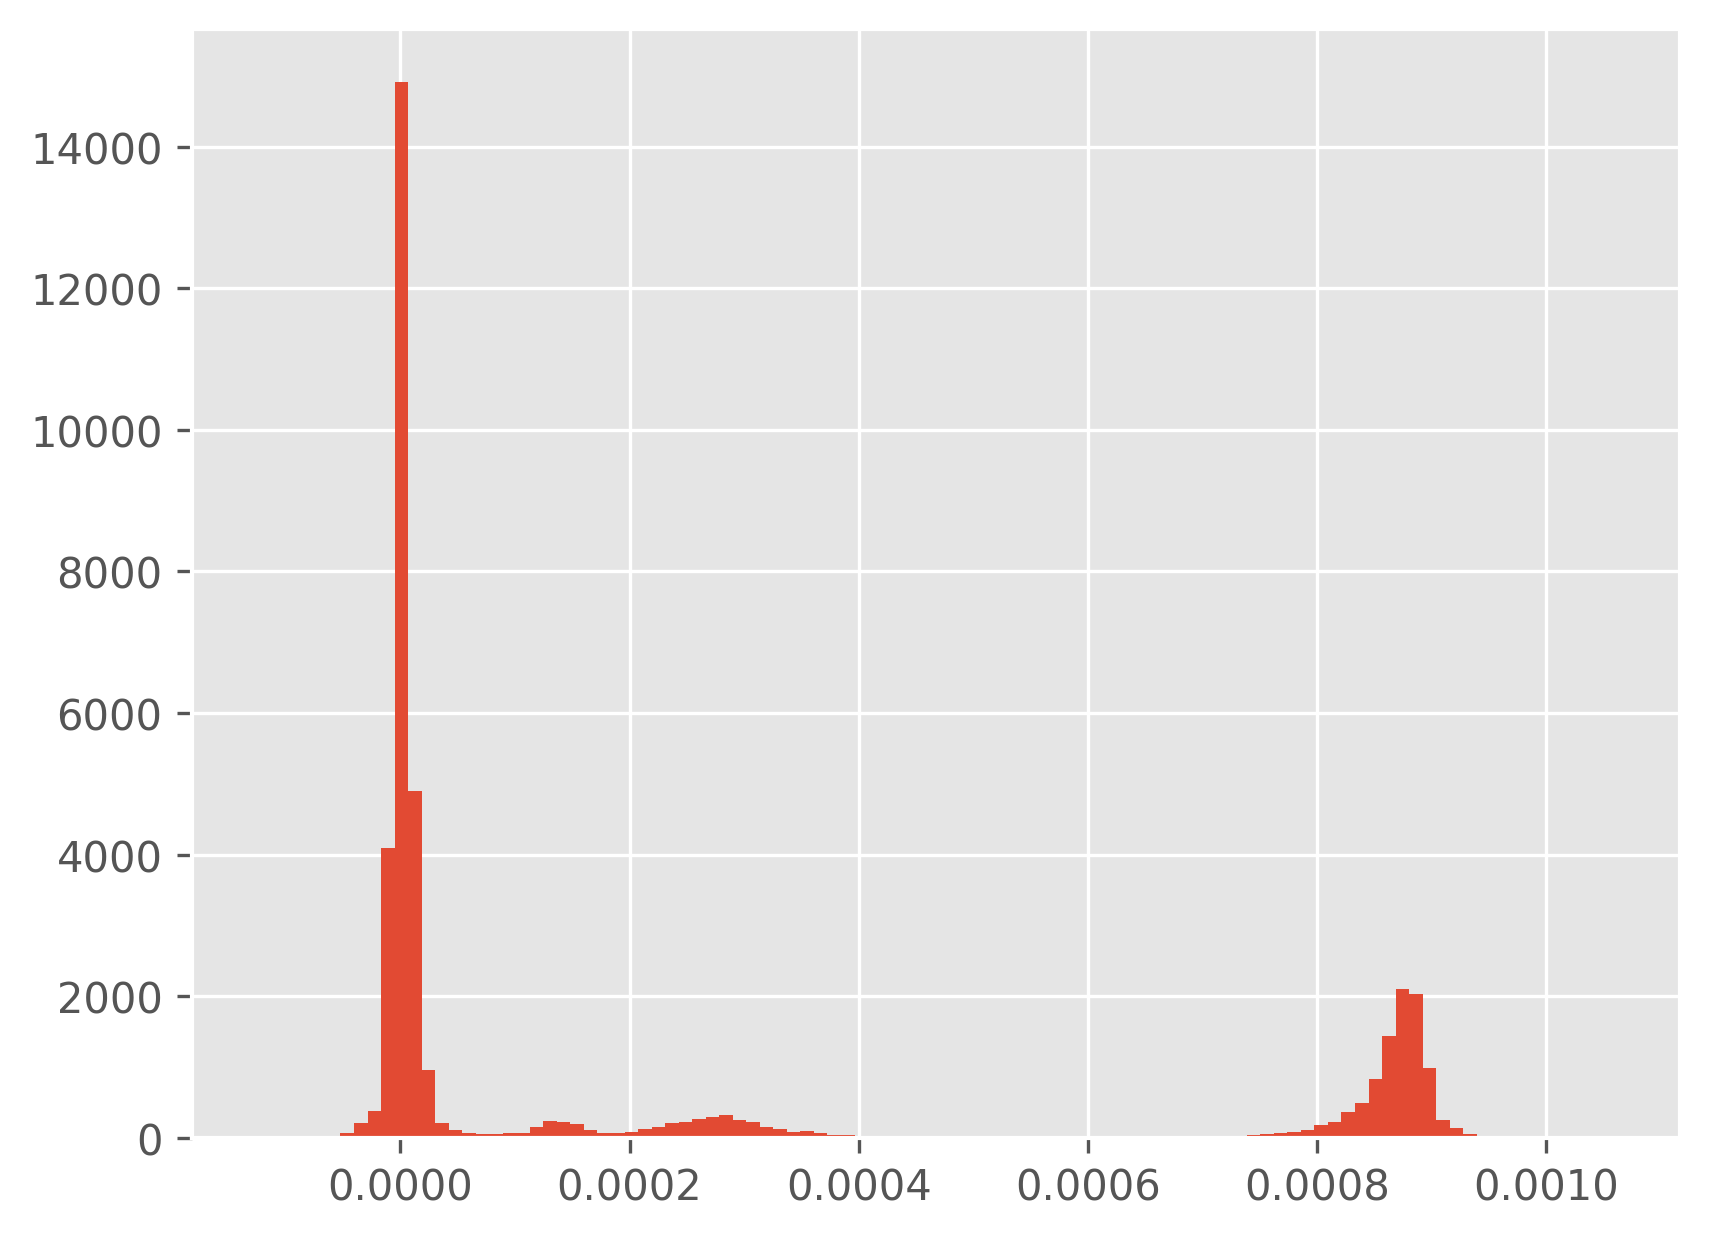

In [70]:
plt.hist(recon_subset.ravel(), bins=100)
plt.show()

In [72]:
range_min = -0.002
range_max = 0.001

In [73]:
recon_uint8 = ru.touint(recon, 'uint8', [range_min, range_max])

### Display reconstruction

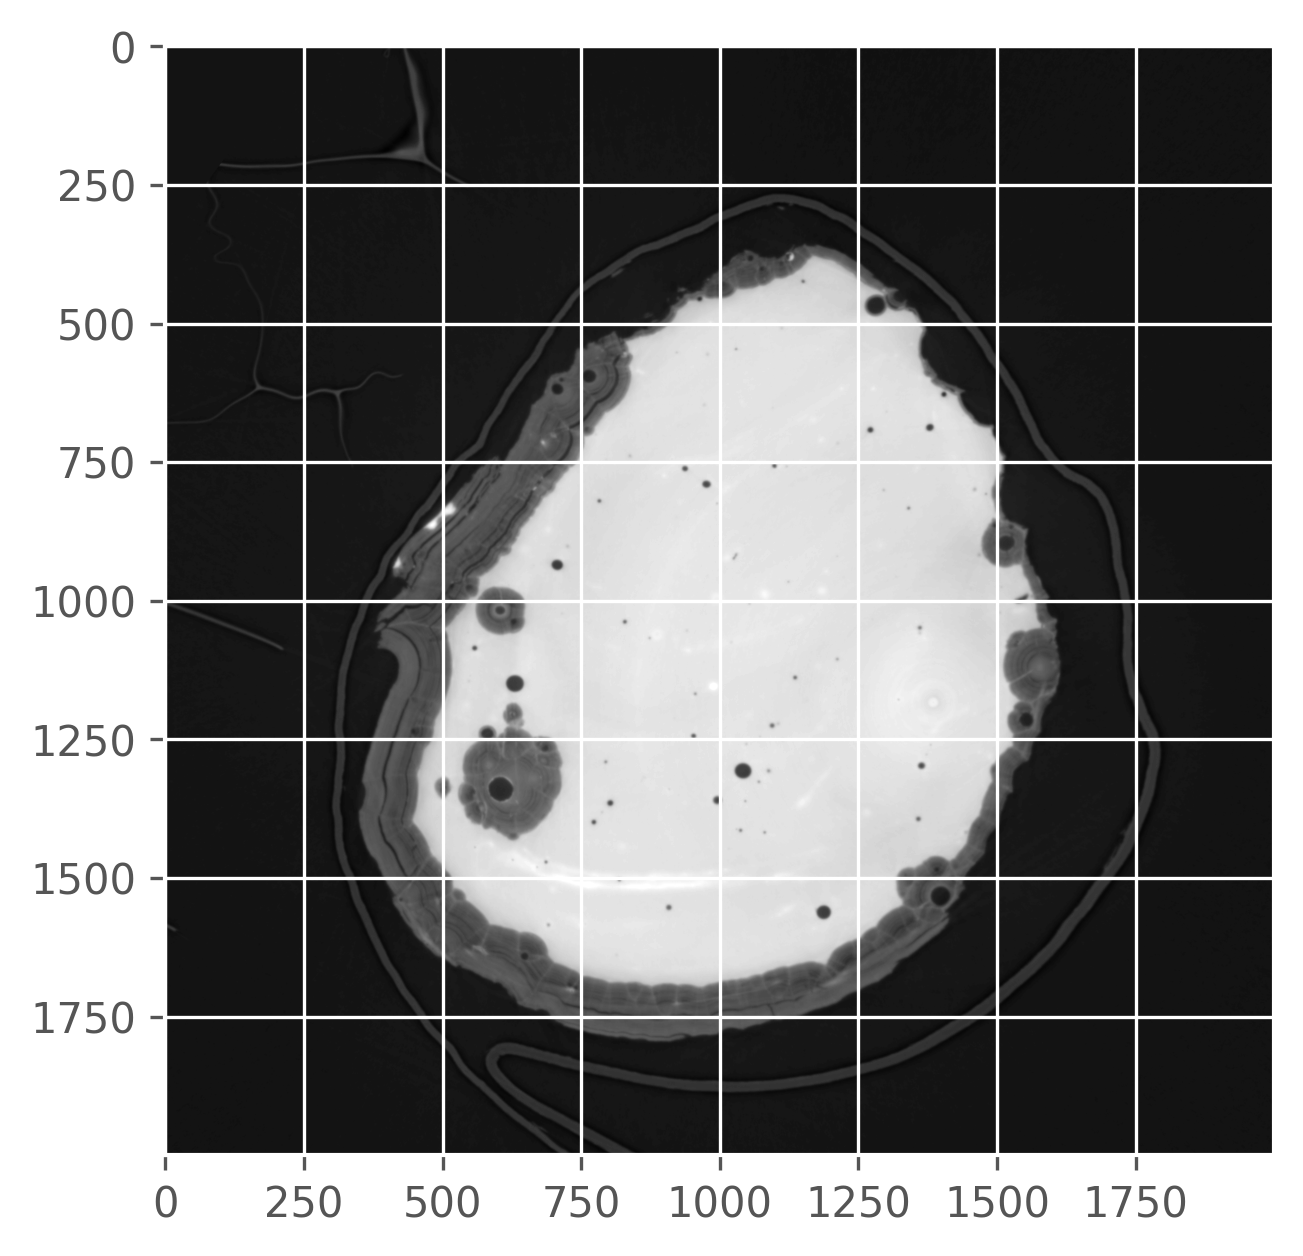

In [74]:
plt.imshow(recon_uint8[5,:,:])

## Write reconstructed dataset
Write output tiff stack as `float32` or `uint8`

In [75]:
fileout = os.path.join(recon_dir, 'slice.tiff')
dxchange.writer.write_tiff_stack(recon_uint8, fname=fileout, axis=0, digit=4, start=0, overwrite=True)

Open virtual stack in ImageJ

In [76]:
os.system(Fiji_exe_stack + fileout + ' &')

0

OpenJDK 64-Bit Server VM warning: ignoring option PermSize=128m; support was removed in 8.0
OpenJDK 64-Bit Server VM warning: Using incremental CMS is deprecated and will likely be removed in a future release


[INFO] Detected existing ImageJ; passing arguments along
Importing .TIFF sequence:
/PETRA/SED/BEATS/IH/2024_recon/khasahwnh/20240222_glass_petra_samah/glass_room-M_stitch-20240222T153555/recon/slice.tiff
Done.
